In [119]:
#----------------------------------------- ASSIGNMENT 3: HOUSE PRICES -----------------------------------------------------------------------
#                                      COMP3122 | KAILIE FIELD | 100627702
#                                               15 November 2024
# REFERENCE: VanderPlas, J.(2017). Python data science handbook: Essential tools for working with data. O'Reilly Media
# CHAPTERS: 
# Chapter 1: Data Loading and Cleaning
# Chapter 2: Data Visualization
# Chapter 3: Data Manipulation with Pandas
# Chapter 4: Visualization with Matplotlib
# Chapter 5: Machine Learning, Machine Learning (regression and model evaluation) 
#-------------------------------------------------------------------------------------------------------------------------------------------

In [189]:
#---- [ IMPORTS ]
#------ Since the data was already split when provided via test.csv and train.csv, train_test_split was redundant
#------ [train.csv] : exclusive to predictions, true labels are unavailable
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.model_selection import train_test_split #<---- unnecessary, presented here to explain thinking process

In [154]:
#---- [ LOADING DATASETS ]
#---- Loading the training and test datasets from CSV files
#------ [house_train] : training the model --> contains features and our target 'SalePrice'
#------ [house_test] : making predictions ---> used for submission file on Kaggle at the end
house_train = pd.read_csv("train.csv")
house_test = pd.read_csv("test.csv")

#---- [ VERIFYING THERE IS NO NaN or INVALID DATA VALUES ]

#---- Extracting baseline statistical information for target 'SalePrice' in house_train dataset
salePrice_data = house_train['SalePrice'].describe()
#---- Verifying whether there are missing (NaN) values in 'SalePrice' --> counting them 
missing_data = house_train['SalePrice'].isnull().sum()
#---- Catching invalid values that are <= 0 (unrealistic for housing prices...especially in this economy)
invalid_data = house_train['SalePrice'][house_train['SalePrice'] <= 0]

#---- [VISUALIZING]
#---- Formatting for readability
print("--------------- STATISTICAL DATA ---------------")
print(f"----------- PRESENT DATA VALUES: {salePrice_data['count']:.0f} ----------")
print("------------------------------------------------")
print(f"MIN: ${salePrice_data['min']:,.2f}")
print(f"MAX: ${salePrice_data['max']:,.2f}")
print(f"STD: ${salePrice_data['std']:,.2f}")
print(f"MEAN: ${salePrice_data['mean']:,.2f}")
print(f"----------- STATISTICAL DATA ---------------")
print(f"MISSING VALUE COUNT: {missing_data}")
print(f"INVALID VALUE COUNT (<= 0): {len(invalid_data)}") #<--- printing the count of invalid prices
print("------------------------------------------------")

--------------- STATISTICAL DATA ---------------
----------- PRESENT DATA VALUES: 1460 ----------
------------------------------------------------
MIN: $34,900.00
MAX: $755,000.00
STD: $79,442.50
MEAN: $180,921.20
----------- STATISTICAL DATA ---------------
MISSING VALUE COUNT: 0
INVALID VALUE COUNT (<= 0): 0
------------------------------------------------


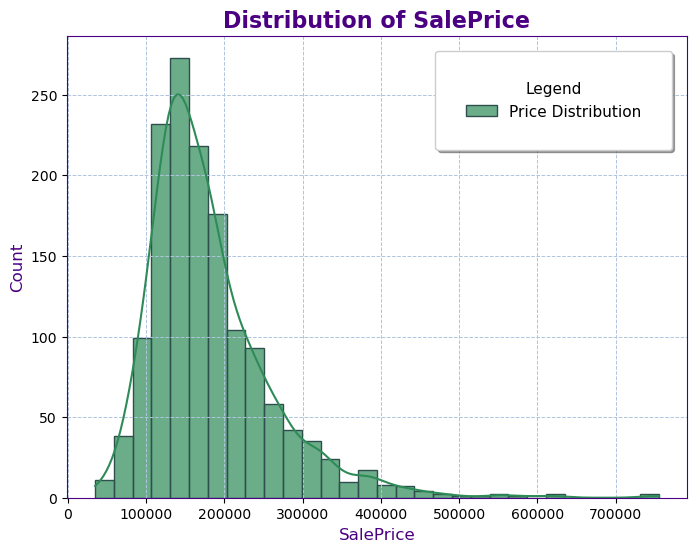

In [192]:
#---- [ STEP 1: VISUALIZING TARGET VARIABLE ]
#---- Visualizing the distribution of our target 'SalePrice' from the training dataset.
#---- Helps understand the spread, tendencies, and the potential skews within the housing prices.
#---- #2E8B57: Sea Green, #2F4F4F: Dark Edges, #4B0082: Indigo Labels, #B0C4DE: Light Steel Blue Grid, #4B0082: Indigo Spines

#---- VISUALIZATIONS for READABILITY
plt.figure(figsize=(8,6))
histogram = sns.histplot(house_train['SalePrice'], kde=True, bins=30, color='#2E8B57', edgecolor='#2F4F4F', alpha=0.7, label='Price Distribution')

#---- TITLES AND LABELS
plt.title('Distribution of SalePrice', fontsize=16, fontweight='bold', color='#4B0082')
plt.xlabel('SalePrice', fontsize=12, color='#4B0082')
plt.ylabel('Count', fontsize=12, color='#4B0082')
plt.grid(True, color='#B0C4DE', linestyle='--', linewidth=0.7)

#---- CUSTOM SPINES --> plt.gca() <--- get current axis
for spine in plt.gca().spines.values():
    spine.set_color('#4B0082')

#---- LEGEND
plt.legend(loc='upper right', fontsize=11, title='Legend', title_fontsize=11, frameon=True, shadow=True, borderpad=2, borderaxespad=1)
    
plt.show(histogram)

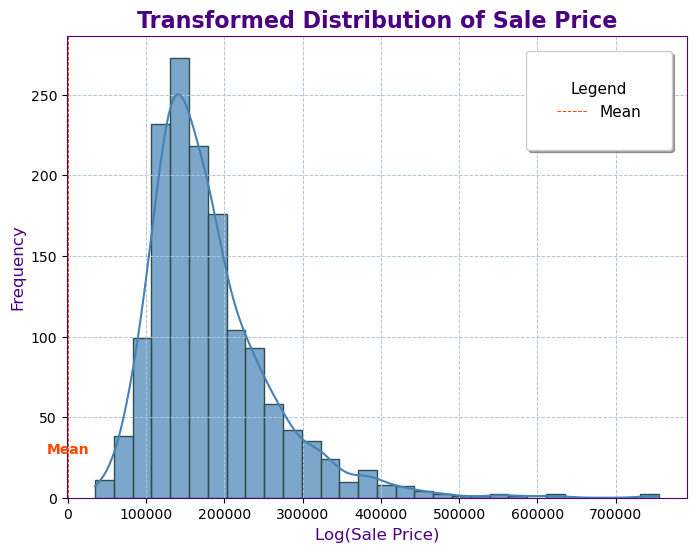

In [184]:
#---- [ APPLYING LOG TRANSFORMATIONS TO PREVENT SKEWNESS ]
#---- [salePrice]: often housing prices are skewed, some exist within the lower price range, others exist with higher ranges
#---- this can affect how well our model will learn
#---- Log reduces the frequency of large numbers which effectively balances the dataset and creates more space for accurate predictions
#---- Focusing on the mean line helps act as a 'balance point'

#---- #4682B4: Blue Histogram, #2F4F4F: Orange Edges, #4B0082: Indigo Labels + Spine Values, #FF4500: Orange Mean Line
house_train['LogSalePrice'] = np.log(house_train['SalePrice'])

#---- visualizing the transformation
plt.figure(figsize=(8,6))

histogram2 = sns.histplot(house_train['SalePrice'], kde=True, bins=30, color='#4682B4', edgecolor='#2F4F4F', alpha=0.7)

#---- Title/Axis Labels
plt.title('Transformed Distribution of Sale Price', fontsize=16, fontweight='bold', color='#4B0082')
plt.xlabel('Log(Sale Price)', fontsize=12, color='#4B0082')
plt.ylabel('Frequency', fontsize=12, color='#4B0082')

#---- Highlighting Transformation using Annotations -- Focusing on the MEAN line
mean = house_train['LogSalePrice'].mean()
plt.text(mean, 30, 'Mean', color='#FF4500', fontweight='bold', ha='center', va='center')
plt.axvline(mean, color='#FF4500', linestyle='--', linewidth=0.7, label='Mean')

#---- Grid Styling
plt.grid(True, color='#B0C4DE', linestyle='--', linewidth=0.7)

#---- Frame Styling (Spines)
for spine in plt.gca().spines.values():
    spine.set_color('#4B0082')
    
#---- Legend
plt.legend(loc='upper right', fontsize=11, title='Legend', title_fontsize=11, frameon=True, shadow=True, borderpad=2, borderaxespad=1)

plt.show(histogram2)

In [171]:
#---- STEP 2: HANDLE MISSING VALUES FOR NUMERICAL FEATURES
#----  After isolating the numerical columns in both training and testing datasets we fill their missing values with the average (mean) of that column. 
#---- This prevents gaps within the data set that could lead to errors during our model training
train_numeric_features = house_train.select_dtypes(include=['number']).columns
test_numeric_features = [col for col in train_numeric_features if col in house_test.columns]

#---- fill missing values for numerical features with the mean of respective columns
house_train[train_numeric_features] = house_train[train_numeric_features].fillna(house_train[train_numeric_features].mean())
house_test[test_numeric_features] = house_test[test_numeric_features].fillna(house_test[test_numeric_features].mean())

#---- VISUALIZE UPDATED STATS FOR NUMERICAL FEATURES
bold = "\033[1m"
reset = "\033[0m"
salePrice_value = ['SalePrice']

statistical_display = {'mean', 'min', 'max', 'std'}
summary = house_train[train_numeric_features].describe()

#---- DISPLAYING IN READABLE FORMAT
print("--------------- TRAINING DATA [NUMERICAL FEATURES] ---------------")
print(f"Total Numerical Features: {house_train[train_numeric_features].shape[1]}")
print("------------------------------------------------------------------")

for stat in statistical_display:
    print(f"{bold}{stat.upper()} VALUES:{reset} ")
    for col in train_numeric_features:
        value = summary.loc[stat, col]
        if col == 'SalePrice':
            print(f"{col:15}{bold}${value:,.2f} <------ TARGET VARIABLE: {stat.upper()}")
        else:
            print(f"{col:15}: {value:,.2f}")
    print("------------------------------------------------------------------")

--------------- TRAINING DATA [NUMERICAL FEATURES] ---------------
Total Numerical Features: 38
------------------------------------------------------------------
MAX VALUES: 
Id             : 1,460.00
MSSubClass     : 190.00
LotFrontage    : 313.00
LotArea        : 215,245.00
OverallQual    : 10.00
OverallCond    : 9.00
YearBuilt      : 2,010.00
YearRemodAdd   : 2,010.00
MasVnrArea     : 1,600.00
BsmtFinSF1     : 5,644.00
BsmtFinSF2     : 1,474.00
BsmtUnfSF      : 2,336.00
TotalBsmtSF    : 6,110.00
1stFlrSF       : 4,692.00
2ndFlrSF       : 2,065.00
LowQualFinSF   : 572.00
GrLivArea      : 5,642.00
BsmtFullBath   : 3.00
BsmtHalfBath   : 2.00
FullBath       : 3.00
HalfBath       : 2.00
BedroomAbvGr   : 8.00
KitchenAbvGr   : 3.00
TotRmsAbvGrd   : 14.00
Fireplaces     : 3.00
GarageYrBlt    : 2,010.00
GarageCars     : 4.00
GarageArea     : 1,418.00
WoodDeckSF     : 857.00
OpenPorchSF    : 547.00
EnclosedPorch  : 552.00
3SsnPorch      : 508.00
ScreenPorch    : 480.00
PoolArea       : 738.0

In [177]:
#---- HANDLE MISSING VALUES FOR CATEGORY FEATURES
#---- After isolating the numerical columns in both training and testing datasets we fill their missing values with most common value (mode) of that column.
#---- This replaces and missing values with the most frequent ones within their respective category, this ensures consistency while remaining unbiased.
train_category_features = house_train.select_dtypes(exclude=['number']).columns
test_category_features = house_test.select_dtypes(exclude=['number']).columns

#---- fill missing values for category features with the mode
house_train[train_category_features] = house_train[train_category_features].fillna(house_train[train_category_features].mode().iloc[0])
house_test[test_category_features] = house_test[test_category_features].fillna(house_train[test_category_features].mode().iloc[0])

#---- VISUALIZE TRAINING DATA SUMMERY FOR CATEGORICAL FEATURES
print("-------------------- TRAINING DATA [CATEGORICAL FEATURES] ---------------")
train_summary = house_train[train_category_features].describe()
print(train_summary)
print("-------------------------------------------------------------------------")
#---- Adding comments to highlight potential issues among features, potential class imbalances or mismatch between datasets.
print("COMMENTS: ")
print(" ----- `UTILITIES` has 2 unique values <------ may not give significant model values")
print(" ----- `MSZoning` dominated by `RL` (1151) <------ CLASS IMBALANCE INDICATED")
print("-------------------- TEST DATA [CATEGORICAL FEATURES]---------------")
test_summary = house_test[test_category_features].describe()
print(test_summary)
print("-------------------------------------------------------------------------")
print("COMMENTS: ")
print(" ----- `UTILITIES` has 1 unique value (`AllPub`) <------ consider dropping")
print(" ----- Count differences in `freq`, `MSZoning` and `Street` between training and test data.")

-------------------- TRAINING DATA [CATEGORICAL FEATURES] ---------------
       MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460  1460     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454  1419      925        1311      1459      1052   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1460         1460       1460  ...       1460         1460   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1382          225       1260  ...        951          686   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1460       1460       1460   1460   1460        1460     1460   
unique          5          5          

In [179]:
#---- STEP 3: ONE-HOT ENCODING
#---- [ONE-HOT ENCODING] : Categorical data nees to be converted into numbers for ML models
#---- creates a separate column for each category which allows the model to utilize the data for modelling
#---- features like 'Neighborhood', 'HouseStyle' or 'MSZoning' are text based, LinearRegression models cant process text, conversion necessary
#---- one-hot ensures that data is transformed into binary columns without losing information in the process
print("---------------------------- ONE-HOT ENCODING -------------------------")
house_train_encoded = pd.get_dummies(house_train, drop_first=True)
house_test_encoded = pd.get_dummies(house_test, drop_first=True)

#----ALIGNING COLUMNS
#--- ensures datasets are consistent despite categorical discrepencies
house_train_encoded, house_test_encoded = house_train_encoded.align(house_test_encoded, join='inner', axis=1)
print(f"Encoded Data Shape[TRAINING]: {house_train_encoded.shape}") #<--- shape is necessary as the number of columns will increase for each unique cat.
print(f"Encoded Data Shape[TESTING]: {house_test_encoded.shape}")
print("-------------------------------------------------------------------------")
print("---------------------------- TRAINING DATA [ENCODED CATEGORIES] -------------------------")
print(house_train_encoded.describe())
print("-------------------------------------------------------------------------")

---------------------------- ONE-HOT ENCODING -------------------------
Encoded Data Shape[TRAINING]: (1460, 227)
Encoded Data Shape[TESTING]: (1459, 227)
-------------------------------------------------------------------------
---------------------------- TRAINING DATA [ENCODED CATEGORIES] -------------------------
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    22.024023    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    60.000000    7553.500000     5.000000   
50%     730.500000    50.000000    70.049958    9478.500000     6.000000   
75%    1095.250000    70.000000    79.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000 

In [127]:
#---- STEP 4: TRAINING
#---- X_train possesses columns from encoded training dataset (excluding LogSalePrice and SalePrice)
#---- LogSalePrice is used as it reduces the skewed output, will improve model performance
X_train = house_train_encoded.drop(columns=['LogSalePrice', 'SalePrice'], errors='ignore')#<-- error="ignore" promises code won't fail if the columns are missing
y_train = house_train['LogSalePrice'] #<--- target variable

#--- training continued
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [128]:
#---- STEP 5: PREDICTIONS
#---- reversing the log transformation
log_predictions = model.predict(house_test_encoded)
predictions = np.exp(log_predictions)
print(predictions)

[117391.35828637 128015.14166652 174991.88902633 ... 156026.755113
 115182.58879476 218131.68182675]


R-SQUARED (R2): 0.93
ROOT MEAN SQUARED: 470155116.45
MEAN SQUARED ERROR: 470155116.45
MEAN ABSOLUTE ERROR: 13281.39


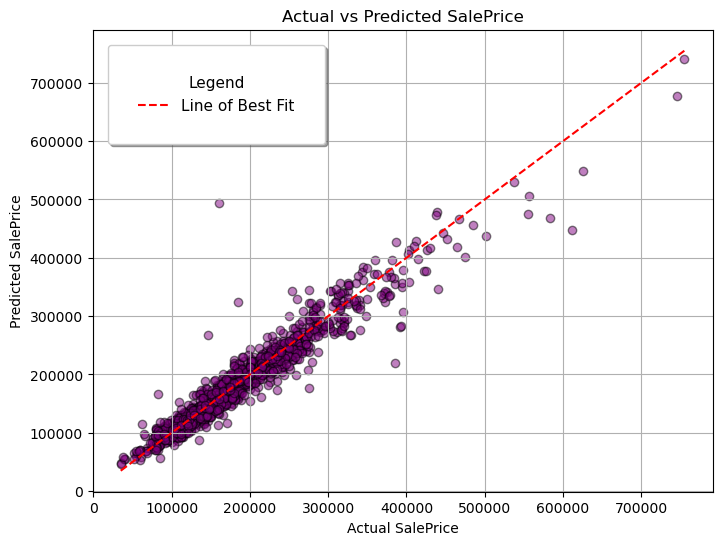

In [182]:
#---- STEP 6: EVALUATING MODEL
#---- To check the performance before we make predictions on unseen data
#---- Using regression metrics to refine accuracy within said performance

#---- Prediction on Training Data
log_y_train_pred = model.predict(X_train)
y_train_pred = np.exp(log_y_train_pred) #<-- by reversing we ensure predictions match original data for evaluation purposes

#---- REGRESSION METRICS
# -- measures how much variance within the target variable can be explained by features (closer to 1 is a good fit)
r2 = r2_score(house_train['SalePrice'], y_train_pred)
#-- 'penalizes' larger errors (less is more)
mean_squared = mean_squared_error(house_train['SalePrice'], y_train_pred) 
#-- average of all absolute errors (less sensitive to outliers)
mean_absolute = mean_absolute_error(house_train['SalePrice'], y_train_pred)
#-- combines MSE and interpretability (same u as target)
root_mean_squared = np.sqrt(mean_squared_error(house_train['SalePrice'], y_train_pred))

#---- VISUALIZING METRICS
print(f"R-SQUARED (R2): {r2:.2f}")
print(f"ROOT MEAN SQUARED: {mean_squared:.2f}")
print(f"MEAN SQUARED ERROR: {mean_squared:.2f}")
print(f"MEAN ABSOLUTE ERROR: {mean_absolute:.2f}")

#---- VISUALIZING ACTUAL VS. PREDICTED SALE PRICE
plt.figure(figsize=(8,6))
plt.scatter(house_train['SalePrice'], y_train_pred, alpha=0.5, color='purple', edgecolor='black')
plt.plot([house_train['SalePrice'].min(), house_train['SalePrice'].max()],
         [house_train['SalePrice'].min(), house_train['SalePrice'].max()],
         color='red', linestyle='--', label='Line of Best Fit')
plt.title('Actual vs Predicted SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.legend(loc='upper left', fontsize=11, title='Legend', title_fontsize=11, frameon=True, shadow=True, borderpad=2, borderaxespad=1)
plt.grid(True)
plt.show()

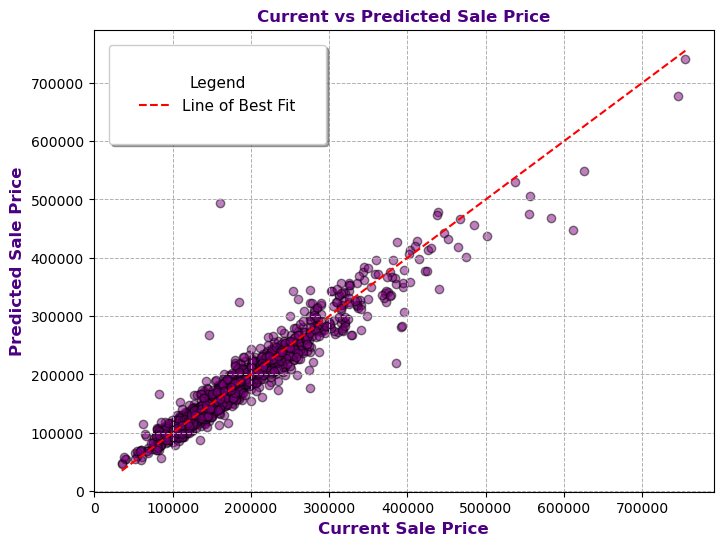

In [188]:
#---- FURTHER VISUALIZATIONS
plt.figure(figsize=(8,6))
plt.scatter(house_train['SalePrice'], y_train_pred, alpha=0.5, color='purple', edgecolor='black')
plt.plot([house_train['SalePrice'].min(), house_train['SalePrice'].max()],
         [house_train['SalePrice'].min(), house_train['SalePrice'].max()],
         color='red', linestyle='--', label='Line of Best Fit')
plt.title('Current vs Predicted Sale Price', fontsize=12, fontweight='bold', color='#4B0082')
plt.xlabel('Current Sale Price', fontsize=12, fontweight='bold', color='#4B0082')
plt.ylabel('Predicted Sale Price', fontsize=12, fontweight='bold', color='#4B0082')
plt.grid(True, linestyle='--', linewidth=0.7)
plt.legend(loc='upper left', fontsize=11, title='Legend', title_fontsize=11, frameon=True, shadow=True, borderpad=2, borderaxespad=1)
plt.show()

In [131]:
#---- STEP 7: AMALGAMATE TO SUBMISSION CSV
submission = pd.DataFrame({'Id': house_test['Id'], 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
#---- logging for personal update
print("---- COMPLETED SUCCESSFULLY")

---- COMPLETED SUCCESSFULLY
